Most methods in this notebook are initially done by David Robinson on his Youtube series Tidy Tuesday screencast with R: https://www.youtube.com/watch?v=AQzZNIyjyWM

This notebook attempts to recreate that analysis by translating it into Python and adding my own further analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels
%matplotlib inline
plt.style.use("ggplot")

In [2]:
wine_rating_df = pd.read_csv('winemag-data-130k-v2.csv')
wine_rating_df.drop(columns='Unnamed: 0', inplace = True)
wine_rating_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
wine_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


In [4]:
wine_rating_df.nunique()

country                      43
description              119955
designation               37979
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64

### Fill in missing countries by matching with existing winery names

The assumption is that each winery only exist in one country (checked with groupby winery then .nunique()). Therefore, Some of the missing 'country' values may be filled in by referring to another data row with a matching 'winery' value.

In [5]:
# List of wineries with one or more missing 'country' values
missing_country = wine_rating_df[wine_rating_df["country"].isnull()]['winery'].unique()
missing_country

array(['Gotsa Family Wines', 'Barton & Guestier',
       'Kakhetia Traditional Winemaking', 'Tsililis', 'Ross-idi',
       'Orbelus', 'St. Donat', 'Familia Deicas', 'Bartho Eksteen',
       'Stone Castle', 'Teliani Valley', 'Undurraga', 'Mt. Beautiful',
       'Neumeister', 'Bachelder', 'Chilcas', 'Santa Ema', 'Psagot',
       'Newton Johnson', 'Ktima Voyatzi', 'Lismore', 'Logodaj',
       'Somlói Vándor', 'Les Frères Dutruy', 'El Capricho',
       'Amiran Vepkhvadze', 'Büyülübağ'], dtype=object)

In [6]:
# only wineries with 'country' values inferable from other data rows are chosen
df_matched_country = wine_rating_df[['country', 'winery']][wine_rating_df['winery'].isin(missing_country)]
missing_country_matchable = df_matched_country.dropna()['winery'].unique()
missing_country_matchable

array(['Undurraga', 'Santa Ema', 'Barton & Guestier', 'Mt. Beautiful',
       'Neumeister', 'Psagot', 'Chilcas', 'Familia Deicas', 'Bachelder',
       'Teliani Valley', 'Bartho Eksteen', 'Newton Johnson', 'Logodaj',
       'Gotsa Family Wines', 'Ktima Voyatzi'], dtype=object)

In [7]:
winery_countery_match_df = wine_rating_df[['country','winery']][(wine_rating_df['winery'].isin(missing_country_matchable)) & (wine_rating_df['country'].notnull())].drop_duplicates(subset = 'winery', keep='first')
winery_countery_match_df.set_index('winery',inplace = True)
winery_countery_match_dict = winery_countery_match_df.to_dict()
for key in winery_countery_match_dict['country']:
    rowidx = wine_rating_df[wine_rating_df['winery'] == key].index
    wine_rating_df.loc[rowidx, 'country'] = winery_countery_match_dict['country'][key]

In [8]:
wine_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129940 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


32 missing 'country' values infered from their 'winery' values

In [9]:
wine_rating_df['country'] = wine_rating_df['country'].fillna(value = 'Missing')
wine_rating_df['taster_name'] = wine_rating_df['taster_name'].fillna(value = 'Missing')

### Extract year from title (only >2000)

In [10]:
wine_rating_df['year'] = wine_rating_df['title'].str.extract(r'(?P<year>20\d\d)')
wine_rating_df['year'] = wine_rating_df['year'].apply(pd.to_numeric)
wine_rating_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [11]:
wine_rating_df[wine_rating_df['year'].isnull()].shape[0]

6345

Note: 6345 wine before year 2000

### EDA (distributions, counts)

In [12]:
wine_rating_df['designation'].value_counts()

Reserve                        2009
Estate                         1322
Reserva                        1259
Riserva                         698
Estate Grown                    621
                               ... 
L- Block                          1
Bric Micca                        1
Baci di Famiglia Chardonnay       1
Les Comtes de Cahors              1
Pence Ranch Clone 2A              1
Name: designation, Length: 37979, dtype: int64

In [13]:
wine_rating_df['country'].value_counts()

US                        54504
France                    22095
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4475
Argentina                  3800
Austria                    3354
Australia                  2329
Germany                    2165
New Zealand                1421
South Africa               1403
Israel                      509
Greece                      468
Canada                      258
Hungary                     146
Bulgaria                    142
Romania                     120
Uruguay                     110
Georgia                      91
Turkey                       90
Slovenia                     87
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Missing                      31
Morocco                      28
Peru                         16
Ukraine 

In [14]:
wine_rating_df['variety'].value_counts()

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
                            ...  
Merlot-Shiraz                   1
Cococciola                      1
Chardonnay-Riesling             1
Gelber Traminer                 1
Mavrokalavryta                  1
Name: variety, Length: 707, dtype: int64

In [15]:
wine_rating_df['taster_name'].value_counts()

Missing               26244
Roger Voss            25514
Michael Schachner     15134
Kerin O’Keefe         10776
Virginie Boone         9537
Paul Gregutt           9532
Matt Kettmann          6332
Joe Czerwinski         5147
Sean P. Sullivan       4966
Anna Lee C. Iijima     4415
Jim Gordon             4177
Anne Krebiehl MW       3685
Lauren Buzzeo          1835
Susan Kostrzewa        1085
Mike DeSimone           514
Jeff Jenssen            491
Alexander Peartree      415
Carrie Dykes            139
Fiona Adams              27
Christina Pickard         6
Name: taster_name, dtype: int64

In [16]:
wine_rating_df.groupby(['country','region_1'])['title'].count().sort_values(ascending = False)

country  region_1                          
US       Napa Valley                           4480
         Columbia Valley (WA)                  4124
         Russian River Valley                  3091
         California                            2629
         Paso Robles                           2350
                                               ... 
France   Apremont                                 1
Italy    Trentino Superiore                       1
US       Napa County-Lake County                  1
         Sonoma County-Santa Barbara County       1
France   Côtes du Roussillon Les Aspres           1
Name: title, Length: 1230, dtype: int64

In [17]:
wine_rating_df.groupby(['variety','designation'])['title'].count().sort_values(ascending = False)

variety                   designation        
Cabernet Sauvignon        Reserve                475
Chardonnay                Reserve                327
Bordeaux-style Red Blend  Barrel sample          300
Pinot Noir                Reserve                282
Sangiovese                Riserva                266
                                                ... 
Red Blend                 Grand Cheval Oregon      1
                          Gran Vos Reserva         1
                          Gran Vino de Guarda      1
                          Gran Tinto               1
Abouriou                  Just                     1
Name: title, Length: 47432, dtype: int64

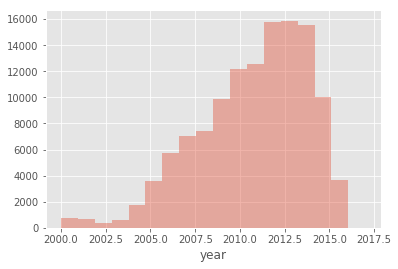

In [18]:
sns.distplot(wine_rating_df[wine_rating_df['year'].notnull()]['year'].astype('int'), kde = False, bins = 18)

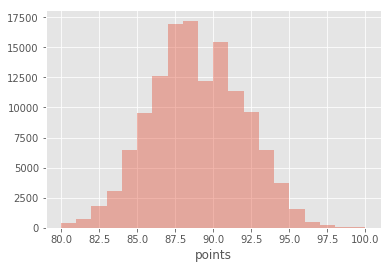

In [19]:
sns.distplot(wine_rating_df[wine_rating_df['points'].notnull()]['points'], kde = False, bins = 20)

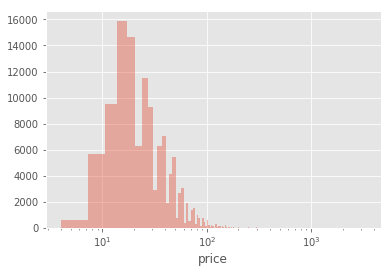

In [20]:
price_plot = sns.distplot(wine_rating_df[wine_rating_df['price'].notnull()]['price'], kde = False, bins = 1000)
price_plot.set_xscale('log')

### Linear Regression (Price)

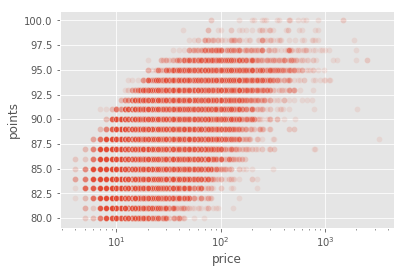

In [21]:
price_rating_plot = sns.scatterplot(x='price', y='points', data = wine_rating_df,alpha = 0.1)
price_rating_plot.set_xscale('log')

In [22]:
import statsmodels.formula.api as smf
price_model = smf.ols('points ~ np.log2(price)', wine_rating_df)
price_model_res = price_model.fit()

## Inspect the results
print(price_model_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                 7.239e+04
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:15:04   Log-Likelihood:            -2.7797e+05
No. Observations:              120975   AIC:                         5.560e+05
Df Residuals:                  120973   BIC:                         5.560e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         78.9814      0.036   2208.

Everytime the price is doubled, the expected wine ratings increases by 2.

### Linear Regression (Price & Country)

As there are too many countries in the data (40+), transform the country data by retaining the top 12 most frequent countries and turn the rest into 'other'

In [23]:
country_count = wine_rating_df['country'].value_counts()
country_count.nlargest(12).index

Index(['US', 'France', 'Italy', 'Spain', 'Portugal', 'Chile', 'Argentina',
       'Austria', 'Australia', 'Germany', 'New Zealand', 'South Africa'],
      dtype='object')

In [24]:
wine_rating_df['country'] = wine_rating_df['country'].fillna(value = 'Missing')
wine_rating_df['country_grouped'] = wine_rating_df['country'].apply(lambda x: x if (x in country_count.nlargest(12).index) else 'other')
wine_rating_df['country_grouped'].value_counts()

US              54504
France          22095
Italy           19540
Spain            6645
Portugal         5691
Chile            4475
Argentina        3800
Austria          3354
other            2549
Australia        2329
Germany          2165
New Zealand      1421
South Africa     1403
Name: country_grouped, dtype: int64

In [25]:
price_country_model = smf.ols('points ~ np.log2(price) + country_grouped', wine_rating_df)
price_country_model_res = price_country_model.fit()

## Inspect the results
print(price_country_model_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     6112.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:15:46   Log-Likelihood:            -2.7580e+05
No. Observations:              120975   AIC:                         5.516e+05
Df Residuals:                  120961   BIC:                         5.518e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

- This model by default uses Argentina as base level (first alphabetically). All other country's coefficients are in comparison with Argentinian wines (eg. Australian wines on average have 1.0916 higher points than Argentinian wines)
- Notice that the coef for price only changes a little compared to previous model (<1% from 1.97 to 1.98). This likely means that price is independent from countries
- R2-squared value is only raised by 0.02. This means that while the country data is statistically significant (all p-values < 0.05), the predictive power of the variable is very low.

In [26]:
price_country_model_US = smf.ols("points ~ np.log2(price) + C(country_grouped, Treatment(reference = 'US'))", wine_rating_df)
price_country_model_US_res = price_country_model_US.fit()

## Inspect the results
print(price_country_model_US_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     6112.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:16:17   Log-Likelihood:            -2.7580e+05
No. Observations:              120975   AIC:                         5.516e+05
Df Residuals:                  120961   BIC:                         5.518e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

- This model changes the default baseline from Argentina to US
- Notice that changing the baseline doesn't affect R2-squared value at all. 

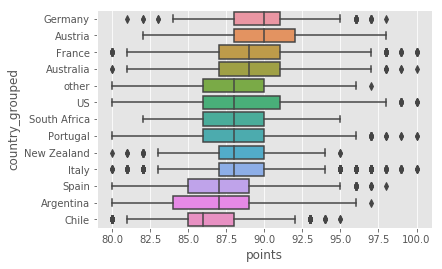

In [27]:
country_grouped_median_sort = wine_rating_df.groupby('country_grouped').median()['points'].sort_values(ascending = False).index

sns.boxplot(x = 'points', y = 'country_grouped', data = wine_rating_df, orient = 'h', order = country_grouped_median_sort)

### Linear Regression (Price + Country + Year)

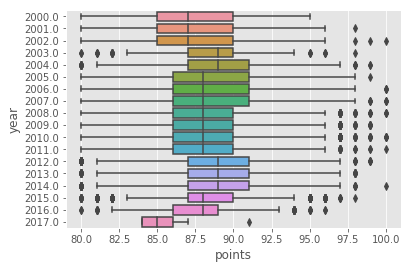

In [29]:
sns.boxplot(x = 'points', y = 'year', data = wine_rating_df, orient = 'h')

Slight trend upwards, 2017 data may be ignored due to low samples

In [30]:
wine_rating_df['year'].value_counts()

2013.0    15875
2012.0    15747
2014.0    15582
2011.0    12558
2010.0    12167
2015.0    10052
2009.0     9878
2008.0     7439
2007.0     7053
2006.0     5772
2016.0     3691
2005.0     3613
2004.0     1774
2000.0      759
2001.0      691
2003.0      598
2002.0      366
2017.0       11
Name: year, dtype: int64

In [31]:
price_country_year_model_US = smf.ols("points ~ np.log2(price) + C(country_grouped, Treatment(reference = 'US')) + year", wine_rating_df)
price_country_year_model_US_res = price_country_year_model_US.fit()
print(price_country_year_model_US_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     5726.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:16:42   Log-Likelihood:            -2.6085e+05
No. Observations:              115155   AIC:                         5.217e+05
Df Residuals:                  115140   BIC:                         5.219e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

While year is statistically significant, the coef is very low. However, adjusted R2 still increased, so year can be kept in the model

### Linear Regression (Price + Country + Year + Taster Name)

In [33]:
wine_rating_df['taster_name'].value_counts()

Missing               26244
Roger Voss            25514
Michael Schachner     15134
Kerin O’Keefe         10776
Virginie Boone         9537
Paul Gregutt           9532
Matt Kettmann          6332
Joe Czerwinski         5147
Sean P. Sullivan       4966
Anna Lee C. Iijima     4415
Jim Gordon             4177
Anne Krebiehl MW       3685
Lauren Buzzeo          1835
Susan Kostrzewa        1085
Mike DeSimone           514
Jeff Jenssen            491
Alexander Peartree      415
Carrie Dykes            139
Fiona Adams              27
Christina Pickard         6
Name: taster_name, dtype: int64

In [34]:
taster_count = wine_rating_df['taster_name'].value_counts()
taster_count.nlargest(10).index

Index(['Missing', 'Roger Voss', 'Michael Schachner', 'Kerin O’Keefe',
       'Virginie Boone', 'Paul Gregutt', 'Matt Kettmann', 'Joe Czerwinski',
       'Sean P. Sullivan', 'Anna Lee C. Iijima'],
      dtype='object')

In [35]:
wine_rating_df['taster_name_grouped'] = wine_rating_df['taster_name'].apply(lambda x: x if (x in taster_count.nlargest(12).index) else 'other')
wine_rating_df['taster_name_grouped'].value_counts()

Missing               26244
Roger Voss            25514
Michael Schachner     15134
Kerin O’Keefe         10776
Virginie Boone         9537
Paul Gregutt           9532
Matt Kettmann          6332
Joe Czerwinski         5147
Sean P. Sullivan       4966
other                  4512
Anna Lee C. Iijima     4415
Jim Gordon             4177
Anne Krebiehl MW       3685
Name: taster_name_grouped, dtype: int64

In [36]:
pr_c_y_tn_model = smf.ols("points ~ np.log2(price) + C(country_grouped, Treatment(reference = 'US')) + year + C(taster_name_grouped, Treatment('Missing'))", wine_rating_df)
pr_c_y_tn_model_res = pr_c_y_tn_model.fit()
print(pr_c_y_tn_model_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     3433.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:17:46   Log-Likelihood:            -2.5823e+05
No. Observations:              115155   AIC:                         5.165e+05
Df Residuals:                  115128   BIC:                         5.168e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

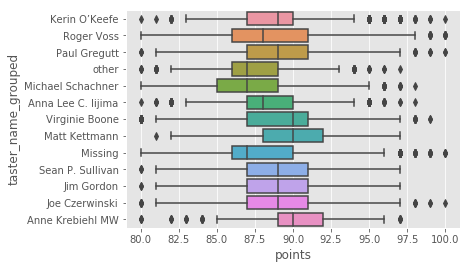

In [37]:
sns.boxplot(x = 'points', y = 'taster_name_grouped', data = wine_rating_df, orient = 'h')

### Coefficient Plot

In [38]:
import re
def beautify_coef_text(x):
    country_compile = re.compile(r"C\(country_grouped\, Treatment\(reference\=\'US\'\)\)\[T\." + r'(.*)' + r"\]")
    taster_compile = re.compile(r"C\(taster_name_grouped\, Treatment\(\'Missing\'\)\)\[T\." + r'(.*)' + r"\]")
    country_res = country_compile.search(x)
    taster_res = taster_compile.search(x)
    if country_res != None:
        return ('country ' + country_res.group(1))
    elif taster_res != None:
        return ('taster_name ' + taster_res.group(1))
    else : return x

model_summary_df = pr_c_y_tn_model_res.conf_int().drop('Intercept')
model_summary_df['coef'] = pr_c_y_tn_model_res.params.drop('Intercept')
model_summary_df.reset_index(inplace = True)
model_summary_df.columns = ['X', 'conf_int_low', 'conf_int_high', 'coef']
model_summary_df['X'] = model_summary_df['X'].apply(beautify_coef_text)
model_summary_df = model_summary_df.sort_values(by = 'coef', ascending = False)
model_summary_df['coef_abs_err'] = model_summary_df['conf_int_high'] - model_summary_df['coef']

model_summary_df

,X,conf_int_low,conf_int_high,coef,coef_abs_err
10,country Spain,2.247594,2.754543,2.501068,0.253475
3,country Chile,2.095829,2.604342,2.350085,0.254257
0,country Argentina,1.910290,2.427094,2.168692,0.258402
8,country Portugal,1.867460,2.179610,2.023535,0.156075
24,np.log2(price),2.003572,2.033714,2.018643,0.015071
9,country South Africa,1.749104,2.087760,1.918432,0.169328
2,country Austria,1.590188,1.941558,1.765873,0.175685
17,taster_name Matt Kettmann,1.689095,1.831694,1.760394,0.071299
5,country Germany,1.461141,1.710204,1.585673,0.124532
14,taster_name Jim Gordon,1.452418,1.617949,1.535183,0.082766


<Container object of 3 artists>

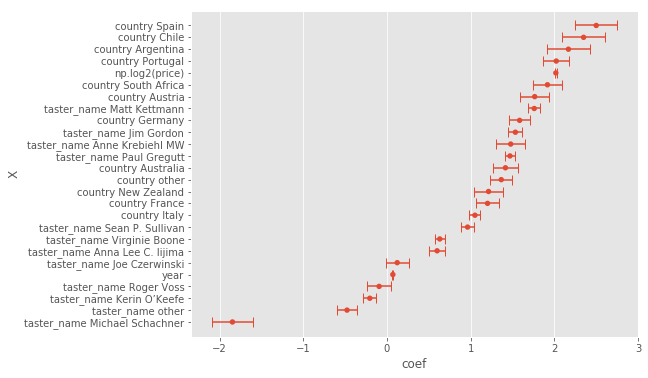

In [47]:
plt.figure(figsize=(8,6))
ax = sns.pointplot('coef', 'X', data=model_summary_df, join = False, markers = '.')
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)


ax.errorbar(x_coords, y_coords, xerr = model_summary_df['coef_abs_err'], fmt='none', capsize = 5)

Text(0.5,0,'fitted values')

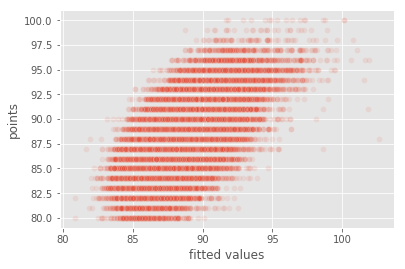

In [48]:
fitted_plot = sns.scatterplot(pr_c_y_tn_model_res.fittedvalues, wine_rating_df['points'], alpha = 0.1)
fitted_plot.set_xlabel('fitted values')

In [55]:
import statsmodels.api as sm

anova_table = sm.stats.anova_lm(pr_c_y_tn_model_res, typ=1)
anova_table['sum_sq/total_sum_sq'] = anova_table['sum_sq'] / anova_table['sum_sq'].sum()
anova_table

,df,sum_sq,mean_sq,F,PR(>F),sum_sq/total_sum_sq
"C(country_grouped, Treatment(reference='US'))",12.0,51888.148692,4324.012391,832.768775,0.000000e+00,0.048894
"C(taster_name_grouped, Treatment('Missing'))",12.0,52914.230409,4409.519201,849.236674,0.000000e+00,0.049861
np.log2(price),1.0,354592.490882,354592.490882,68291.560585,0.000000e+00,0.334134
year,1.0,4051.727356,4051.727356,780.328945,3.820325e-171,0.003818
Residual,115128.0,597782.858386,5.192333,NaN,NaN,0.563293


Price has the highest explained variance (0.334), i.e. it is the strongest predictor for price